This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ... Or you can make the input file name(s) anything you want.

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the RATIO OF BADS TO GOODS retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. I think in general it's better to keep balance = 0.

The filter is pretty fast. The wrapper is what takes the most time. The two most important paramenters are the number of variables you want to save from the filter (num_filter) and the number you want from the wrapper (num_wrapper). 

There's a parameter njobs that controls the # threads used in the wrapper. Set it to 1 for a single thread and it should work fine, but you might be able to succeed with njobs = -1, which lets the machine set the maximum # threads based on the CPU. With this setting the kernel may die because of memory. The njobs = -1 doesn't take into consideration the memory requirements.

Recommendations: Try a few simple runs just to make sure all's working. Start with num_filter = 20, num_wrapper = 5, increase from there. I like num_filter as high as around 10 to 20% of the # candidate variables, but not much higher than a few hundred. You don't need num_wrapper large if you're doing forward selection. Most problems will saturate before 20. You can try a few different simple wrapper models like RF (5 trees, 10 layers), catboost (10 trees, 3 layers), LGBM (same). They're pretty fast. You can try forward and backward. I'd start with forward. In the end, select one of these as your favorite run and go with those variables. Don't mix variables across different runs.

I find forward selection runs much faster than backward.

Make sure your validation/out-of-time population and any other record exclusion is set correctly and as you want for your problem in cell 3.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 200
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'candidate_variables.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 85264] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 3466] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables.csv size is (97496, 2635)


<timed exec>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Amount' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
candidate_variables.csv                     variable  filter score
1                      Fraud      1.000000
28           Cardnum_total_3      0.621932
19           Cardnum_total_1      0.619658
10           Cardnum_total_0      0.591318
15           Cardnum_count_1      0.567429
37           Cardnum_total_7      0.564245
24           Cardnum_count_3      0.563356
586         Card_dow_total_7      0.542303
17             Cardnum_max_1      0.532080
33           Cardnum_count_7      0.526897
8              Cardnum_max_0      0.525418
6            Cardnum_count_0      0.516123
595        Card_dow_total_14      0.511203
1577   Cardnum_vdratio_1by30      0.504966
1578   Cardnum_vdratio_1by60      0.502927
26             Cardnum_max_3      0.501170
46          Cardnum_total_14      0.494375
1645  Card_dow_vdratio_0by30      0.489227
1646  Card_dow_vdratio_0by60      0.48

In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [5]:
filter_score.head(30)

,variable,filter score
0,Fraud,1.000000
1,Cardnum_total_3,0.621932
2,Cardnum_total_1,0.619658
3,Cardnum_total_0,0.591318
4,Cardnum_count_1,0.567429
5,Cardnum_total_7,0.564245
6,Cardnum_count_3,0.563356
7,Card_dow_total_7,0.542303
8,Cardnum_max_1,0.532080
9,Cardnum_count_7,0.526897


In [6]:
filter_score.tail(10)

,variable,filter score
2625,card_merch_unique_count_for_card_state_7,0.000088
2626,Merchnum_desc_Zip_unique_count_for_Merchnum_de...,0.000075
2627,card_merch_unique_count_for_card_state_3,0.000063
2628,Merchdesc_Zip_unique_count_for_Merchdesc_State_14,0.000038
2629,Merchdesc_Zip_unique_count_for_Merchdesc_State_7,0.000038
2630,Card_Merchdesc_Zip_unique_count_for_Merchdesc_...,0.000038
2631,merch_zip_unique_count_for_merch_state_14,0.000025
2632,merch_zip_unique_count_for_merch_state_7,0.000013
2633,Merchnum_desc_Zip_unique_count_for_Merchnum_de...,0.000013
2634,card_merch_unique_count_for_Cardnum_1,0.000000


In [7]:
filter_score.shape

(2635, 2)

In [8]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['Cardnum_total_3', 'Cardnum_total_1', 'Cardnum_total_0', 'Cardnum_count_1', 'Cardnum_total_7', 'Cardnum_count_3', 'Card_dow_total_7', 'Cardnum_max_1', 'Cardnum_count_7', 'Cardnum_max_0', 'Cardnum_count_0', 'Card_dow_total_14', 'Cardnum_vdratio_1by30', 'Cardnum_vdratio_1by60', 'Cardnum_max_3', 'Cardnum_total_14', 'Card_dow_vdratio_0by30', 'Card_dow_vdratio_0by60', 'Card_dow_max_7', 'Cardnum_vdratio_1by14', 'Cardnum_variability_max_0', 'Card_dow_count_7', 'Cardnum_actual/toal_0', 'Card_dow_vdratio_0by14', 'Cardnum_variability_max_1', 'Cardnum_unique_count_for_card_state_1', 'Cardnum_unique_count_for_card_zip_1', 'Card_dow_total_30', 'Cardnum_unique_count_for_Merchnum_1', 'Card_dow_max_14', 'Card_dow_vdratio_0by7', 'Cardnum_vdratio_1by7', 'Cardnum_unique_count_for_card_state_3', 'Cardnum_unique_count_for_card_zip_3', 'Cardnum_total_amount_1_by_60', 'Cardnum_unique_count_for_Merchnum_3', 'Cardnum_actual/toal_1', 'Card_dow_unique_count_for_merch_state_1', 'Card_dow_unique_cou

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,Cardnum_total_3,Cardnum_total_1,Cardnum_total_0,Cardnum_count_1,Cardnum_total_7,Cardnum_count_3,Card_dow_total_7,Cardnum_max_1,Cardnum_count_7,Cardnum_max_0,...,Card_dow_variability_max_30,Cardnum_unique_count_for_Merchnum_60,Card_Merchnum_desc_total_60,card_merch_max_7,Card_Merchnum_State_max_7,Card_Merchnum_Zip_max_7,card_state_max_14,Merchnum_desc_Zip_total_3,Card_Merchnum_State_total_60,card_merch_total_60
Recnum,,,,,,,,,,,,,,,,,,,,,
3466,1964.73,1551.02,333.47,3,3591.53,7,333.47,930.41,9,333.47,...,0.00,13,1960.27,983.66,983.66,983.66,983.66,854.06,1960.27,1960.27
3467,834.91,660.87,4.37,2,997.73,34,109.97,656.50,72,4.37,...,11.03,3,4.37,15.40,15.40,15.40,15.40,4.37,499.22,499.22
3468,8459.94,2904.08,271.93,7,9674.14,14,271.93,1380.45,17,271.93,...,0.00,21,2306.98,278.73,278.73,278.73,554.38,582.94,2306.98,2306.98
3469,838.53,664.49,7.99,3,1001.35,35,113.59,656.50,73,4.37,...,11.78,3,7.99,15.40,15.40,15.40,15.40,7.99,502.84,502.84
3470,16.28,16.28,16.28,1,16.28,1,16.28,16.28,1,16.28,...,0.00,1,16.28,16.28,16.28,16.28,16.28,130.15,16.28,16.28


In [10]:
df_keep.shape

(81476, 200)

In [11]:
Y.head()

,Fraud
Recnum,
3466,0
3467,0
3468,0
3469,0
3470,0


In [12]:
Y = Y.values.ravel()
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[0 0 0 ... 0 0 0]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:47.439063


In [15]:
print(X.shape,Y.shape)

(81476, 200) (81476,)


In [16]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [17]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)

In [18]:
def fdr(classifier, x, y, cutoff=0.03):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
        y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
    y_prob = y_prob.flatten()  # Ensure y_prob is 1D
    num_fraud = np.sum(y == 1)  # Count the total number of frauds

    # Sort the proba list from high to low while retaining the true (not predicted) fraud label
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

    # Return the FDR score (#fraud_in_cutoff / #total_fraud)
    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

## Run a wrapper on the remaining top variables

In [19]:
# This is a parallel running parameter. You can try it set to -1, but sometimes the data is too large to
# be divided into that many threads and the next cell quits. A safe value is 1 for no parallelization but it 
# the runs slower. You might experiment to see how big you can set this for your data on your machine.
njobs = -1

In [20]:
%%time
import warnings 
warnings.filterwarnings("ignore") 

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 14.1 µs


In [21]:
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

nfeatures = len(X.columns)
#clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=1)
#clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)
#clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
#clf = LGBMClassifier(n_estimators=10,num_leaves=3) # simple, fast nonlinear model for the wrapper
#clf = MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='adam', max_iter=200, random_state=42)
#clf = LogisticRegression()
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for backward selection
sfs.fit(X,Y)

/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/Users/pin/miniconda3/envs/py3k/lib/python3.10/site-

SequentialFeatureSelector(cv=2,
                          estimator=<catboost.core.CatBoostClassifier object at 0x3092d1c00>,
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x17600ef80>)

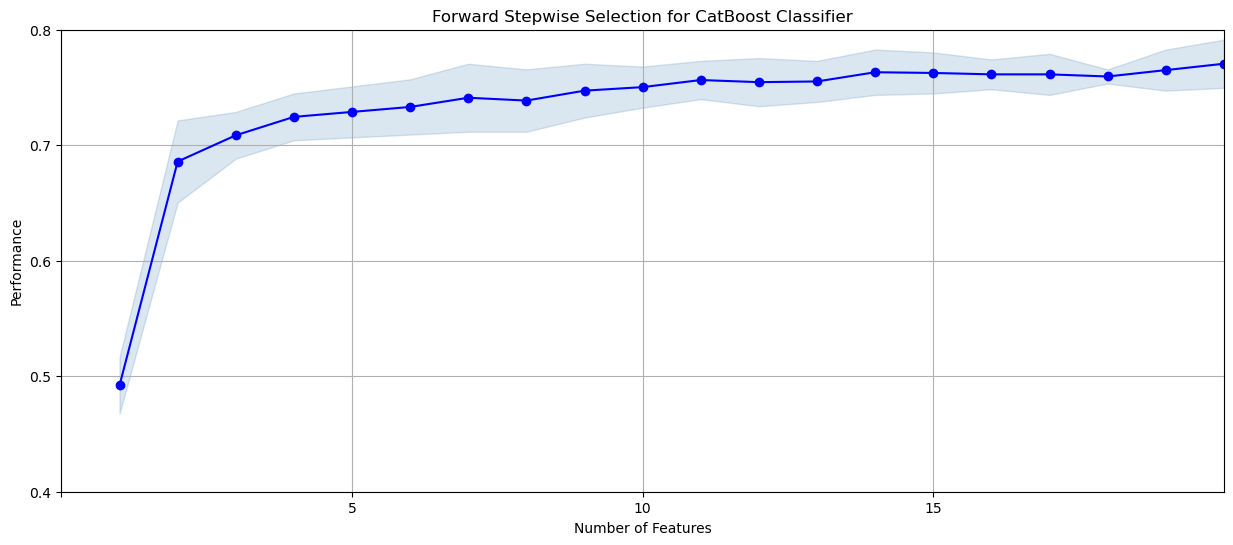

In [22]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, num_wrapper, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.4,.8])
plt.xlim(0,num_wrapper)
plt.title('Forward Stepwise Selection for CatBoost Classifier')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [23]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [24]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [25]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(25,)","[0.5165644171779141, 0.46748466257668714]",0.492025,"(Cardnum_unique_count_for_card_state_1,)",0.105587,0.02454,0.02454,1.0,Cardnum_unique_count_for_card_state_1
2,"(25, 145)","[0.7214723926380369, 0.6503067484662577]",0.68589,"(Cardnum_unique_count_for_card_state_1, Card_M...",0.153101,0.035583,0.035583,2.0,Card_Merchdesc_State_total_3
3,"(25, 145, 196)","[0.7288343558282209, 0.6883435582822086]",0.708589,"(Cardnum_unique_count_for_card_state_1, Card_M...",0.087109,0.020245,0.020245,3.0,card_state_max_14
4,"(25, 65, 145, 196)","[0.7447852760736197, 0.7042944785276074]",0.72454,"(Cardnum_unique_count_for_card_state_1, Cardnu...",0.087109,0.020245,0.020245,4.0,Cardnum_vdratio_0by30
5,"(25, 65, 142, 145, 196)","[0.750920245398773, 0.7067484662576687]",0.728834,"(Cardnum_unique_count_for_card_state_1, Cardnu...",0.095028,0.022086,0.022086,5.0,card_state_total_amount_1_by_60
6,"(1, 25, 65, 142, 145, 196)","[0.7570552147239263, 0.7092024539877301]",0.733129,"(Cardnum_total_1, Cardnum_unique_count_for_car...",0.102947,0.023926,0.023926,6.0,Cardnum_total_1
7,"(1, 25, 65, 132, 142, 145, 196)","[0.7705521472392638, 0.7116564417177914]",0.741104,"(Cardnum_total_1, Cardnum_unique_count_for_car...",0.126704,0.029448,0.029448,7.0,Card_Merchdesc_Zip_total_7
8,"(1, 7, 25, 65, 132, 142, 145, 196)","[0.7656441717791411, 0.7116564417177914]",0.73865,"(Cardnum_total_1, Cardnum_max_1, Cardnum_uniqu...",0.116145,0.026994,0.026994,8.0,Cardnum_max_1
9,"(1, 7, 25, 65, 132, 142, 145, 171, 196)","[0.7705521472392638, 0.7239263803680982]",0.747239,"(Cardnum_total_1, Cardnum_max_1, Cardnum_uniqu...",0.100307,0.023313,0.023313,9.0,state_des_total_1
10,"(1, 7, 25, 65, 132, 142, 145, 147, 171, 196)","[0.7680981595092025, 0.7325153374233129]",0.750307,"(Cardnum_total_1, Cardnum_max_1, Cardnum_uniqu...",0.07655,0.017791,0.017791,10.0,card_zip_total_amount_1_by_60


In [26]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [27]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1      Cardnum_unique_count_for_card_state_1
2               Card_Merchdesc_State_total_3
3                          card_state_max_14
4                      Cardnum_vdratio_0by30
5            card_state_total_amount_1_by_60
6                            Cardnum_total_1
7                 Card_Merchdesc_Zip_total_7
8                              Cardnum_max_1
9                          state_des_total_1
10             card_zip_total_amount_1_by_60
11                          card_state_max_0
12                         state_des_total_3
13     Card_dow_unique_count_for_merch_zip_1
14    Card_dow_unique_count_for_merch_zip_60
15                          Card_dow_count_7
16     Cardnum_unique_count_for_card_state_3
17                          Card_dow_total_7
18                             Cardnum_avg_1
19                          Cardnum_count_14
20                     Cardnum_vdratio_1by30
Name: variable name, dtype: object

In [28]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
Cardnum_total_3,0.621932
Cardnum_total_1,0.619658
Cardnum_total_0,0.591318
Cardnum_count_1,0.567429
Cardnum_total_7,0.564245
...,...
Card_Merchdesc_Zip_unique_count_for_Merchdesc_State_60,0.000038
merch_zip_unique_count_for_merch_state_14,0.000025
merch_zip_unique_count_for_merch_state_7,0.000013


In [29]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
Cardnum_unique_count_for_card_state_1
Card_Merchdesc_State_total_3
card_state_max_14
Cardnum_vdratio_0by30
card_state_total_amount_1_by_60


In [30]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [31]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,Cardnum_unique_count_for_card_state_1,0.476067
1,2,Card_Merchdesc_State_total_3,0.319700
2,3,card_state_max_14,0.305946
3,4,Cardnum_vdratio_0by30,0.413436
4,5,card_state_total_amount_1_by_60,0.320248
5,6,Cardnum_total_1,0.619658
6,7,Card_Merchdesc_Zip_total_7,0.324118
7,8,Cardnum_max_1,0.532080
8,9,state_des_total_1,0.311366
9,10,card_zip_total_amount_1_by_60,0.319570


In [32]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['Cardnum_unique_count_for_card_state_1',
 'Card_Merchdesc_State_total_3',
 'card_state_max_14',
 'Cardnum_vdratio_0by30',
 'card_state_total_amount_1_by_60',
 'Cardnum_total_1',
 'Card_Merchdesc_Zip_total_7',
 'Cardnum_max_1',
 'state_des_total_1',
 'card_zip_total_amount_1_by_60',
 'card_state_max_0',
 'state_des_total_3',
 'Card_dow_unique_count_for_merch_zip_1',
 'Card_dow_unique_count_for_merch_zip_60',
 'Card_dow_count_7',
 'Cardnum_unique_count_for_card_state_3',
 'Card_dow_total_7',
 'Cardnum_avg_1',
 'Cardnum_count_14',
 'Cardnum_vdratio_1by30',
 'Recnum',
 'Fraud']

In [33]:
filter_score

,filter score
variable,
Cardnum_total_3,0.621932
Cardnum_total_1,0.619658
Cardnum_total_0,0.591318
Cardnum_count_1,0.567429
Cardnum_total_7,0.564245
...,...
Card_Merchdesc_Zip_unique_count_for_Merchdesc_State_60,0.000038
merch_zip_unique_count_for_merch_state_14,0.000025
merch_zip_unique_count_for_merch_state_7,0.000013


In [34]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 12.2 s, sys: 2.86 s, total: 15.1 s
Wall time: 15.6 s


(97496, 2635)

In [35]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(97496, 22)


In [36]:
df_keep.to_csv('vars_final.csv',index=False)

In [37]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:11:30.385228


In [38]:
#%pwd